# ДЗ к уроку №4. Деревья решений

## 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

In [1]:
from graphviz import Digraph

In [2]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

### Критерии останова

_Критерии останова_ - это критерии, которые показывают, нужно ли остановить процесс построения дерева. Правильный выбор критериев останова роста дерева может существенно повлиять на его качество. Существует большое количество возможных ограничений:

- Ограничение максимальной глубины дерева. Этот критерий считается достаточно грубым, но хорошо зарекомендовавшим себя в построении композиций деревьев - когда несколько деревьев объединяются в один алгоритм.


- Ограничение максимального количества листьев.


- Ограничение минимального количества $n$ объектов в листе. При этом оно должно быть достаточным, чтобы построить надежный прогноз.


- Останов в случае, когда все объекты в листе относятся к одному классу.


- Требование улучшения функционала качества при разбиении на какую-то минимальную величину.

Подбор оптимальных критериев - сложная задача, которая обычно решается методом кросс-валидации.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [4]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 5, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

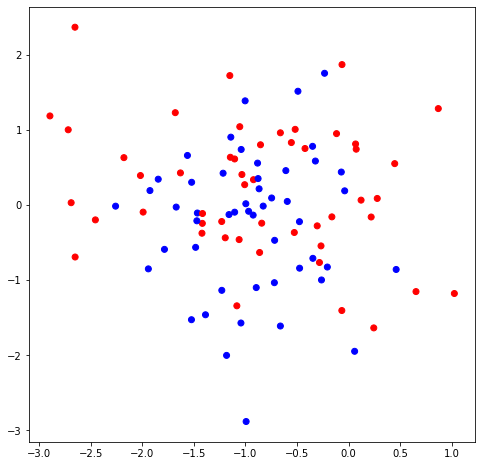

In [5]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [6]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [8]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1    # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, n_features, n_leafs):
    
    #  обозначим минимальное количество объектов в узле
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    if n_features > data.shape[1]:
        n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее n_leafs объектов
            if len(true_data) < n_leafs or len(false_data) < n_leafs:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, n_features, n_leafs):

    quality, t, index = find_best_split(data, labels, n_features, n_leafs)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, n_features, n_leafs)
    false_branch = build_tree(false_data, false_labels, n_features, n_leafs)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [14]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [15]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [16]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [17]:
def compare(n_features, n_leafs, train_data=train_data, test_data=test_data,
               train_labels=train_labels, test_labels=test_labels):
    tree = build_tree(train_data, train_labels, n_features, n_leafs)
    train_res = predict(train_data, tree)
    result = predict(test_data, tree)
    train_ac = accuracy_metric(train_labels, train_res)
    test_ac = accuracy_metric(test_labels, result)
    print(f'Features: {n_features}, leafs: {n_leafs}')
    print(f'Accuracy: train={train_ac:.4f}, test={test_ac:.4f}')
    return test_ac

In [18]:
best_ac = 0
feat_best = 0
leaf_best = 0

for i in range(2,5):
    for j in range(3,7):
        compare(i, j)
        if compare(i, j) > best_ac:
            best_ac = compare(i, j)
            feat_best = i
            leaf_best = j
        print('\n')
print(f'\nЛучшие критерии останова: \nКоличество признаков: {feat_best} \nМинимальное количество листьев: {leaf_best}')

Features: 2, leafs: 3
Accuracy: train=87.1429, test=46.6667
Features: 2, leafs: 3
Accuracy: train=87.1429, test=46.6667
Features: 2, leafs: 3
Accuracy: train=87.1429, test=46.6667


Features: 2, leafs: 4
Accuracy: train=82.8571, test=53.3333
Features: 2, leafs: 4
Accuracy: train=82.8571, test=53.3333
Features: 2, leafs: 4
Accuracy: train=82.8571, test=53.3333


Features: 2, leafs: 5
Accuracy: train=82.8571, test=53.3333
Features: 2, leafs: 5
Accuracy: train=82.8571, test=53.3333


Features: 2, leafs: 6
Accuracy: train=82.8571, test=53.3333
Features: 2, leafs: 6
Accuracy: train=82.8571, test=53.3333


Features: 3, leafs: 3
Accuracy: train=88.5714, test=56.6667
Features: 3, leafs: 3
Accuracy: train=88.5714, test=56.6667
Features: 3, leafs: 3
Accuracy: train=88.5714, test=56.6667


Features: 3, leafs: 4
Accuracy: train=82.8571, test=53.3333
Features: 3, leafs: 4
Accuracy: train=82.8571, test=53.3333


Features: 3, leafs: 5
Accuracy: train=82.8571, test=53.3333
Features: 3, leafs: 5
Accura